# Análisis de datos de twitter con Comprehend

## Recuperación de datos con tweepy

In [149]:
!pip install tweepy --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [178]:
import json
import boto3
import os
import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener
import pandas as pd

In [151]:
consumer_key = ""
consumer_secret = ""
access_token = ""
access_token_secret = ""
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

In [152]:
twitter_stream = Stream(auth,MyListener())
twitter = tweepy.API(auth)

In [153]:
class MyListener(StreamListener):
    def on_data(self,data):
        try:
            tweet = json.loads(data)
            print(tweet['created_at'])
            print(tweet['text'])
            print(tweet['user']['name'])
            print(tweet['user']['location'])
            return True
        except Exception as e:
            print (e)
            return True
    def on_error(self,status):
        print(status)
        return True

In [ ]:
twitter_stream.filter(track=["aws"])

In [155]:
tweets = twitter.search(lang='es',q="awscloud",location="Chile")

In [172]:
filename = "tweets.json"
try:
    with open(filename, "r") as f:
        print("file exists, deleting")
    os.remove(filename)
except:
    print("ok, file don't exists")

ok, file don't exists


In [173]:
with open(filename, "a") as f:
    f.write("[\r\n")
    i = 0
    for tweet in tweets:
        i+=1
        f.write(json.dumps(tweet._json)+"\r\n")
        if(i < len(tweets)):
            f.write(",")
    f.write("\r\n]")

In [174]:
df = pd.read_json(filename)

In [176]:
df.head()

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,extended_entities
0,2021-08-27 03:49:42+00:00,1431101591088734211,1431101591088734208,RT @MonicaOspinaL: Gracias @awscloud por este ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,NaN,{'created_at': 'Thu Aug 26 00:19:54 +0000 2021...,False,2,0,False,False,es,NaN,NaN
1,2021-08-26 22:30:06+00:00,1431021160188157952,1431021160188157952,RT @AleRam0923: #java #springboot #microservic...,False,"{'hashtags': [{'text': 'java', 'indices': [16,...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://help.twitter.com/en/using-twi...",NaN,NaN,...,NaN,{'created_at': 'Thu Aug 26 20:56:58 +0000 2021...,False,3,0,False,False,es,NaN,NaN
2,2021-08-26 22:13:32+00:00,1431016993600249866,1431016993600249856,RT @AleRam0923: #java #springboot #microservic...,False,"{'hashtags': [{'text': 'java', 'indices': [16,...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://script.google.com"" rel=""nofol...",NaN,NaN,...,NaN,{'created_at': 'Thu Aug 26 20:56:58 +0000 2021...,False,3,0,False,False,es,NaN,NaN
3,2021-08-26 21:47:24+00:00,1431010416633683973,1431010416633683968,RT @AleRam0923: #java #springboot #microservic...,False,"{'hashtags': [{'text': 'java', 'indices': [16,...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://help.twitter.com/en/using-twi...",NaN,NaN,...,NaN,{'created_at': 'Thu Aug 26 20:56:58 +0000 2021...,False,3,0,False,False,es,NaN,NaN
4,2021-08-26 21:01:08+00:00,1430998772293804038,1430998772293804032,Las organizaciones están utilizando datos para...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""http://www.everyonesocial.com"" rel=""n...",NaN,NaN,...,NaN,NaN,False,0,0,False,False,es,0.0,NaN


## Análisis de sentimiento

In [179]:
comprehend = boto3.client('comprehend')

In [219]:
sentiment = comprehend.batch_detect_sentiment(LanguageCode="es",TextList=df['text'].tolist())

In [223]:
sentiment['ResultList'][0]

{'Index': 0,
 'Sentiment': 'POSITIVE',
 'SentimentScore': {'Positive': 0.8761889934539795,
  'Negative': 0.00015693411114625633,
  'Neutral': 0.12316233664751053,
  'Mixed': 0.000491808052174747}}

In [224]:
sentimentList = [result['Sentiment'] for result in sentiment['ResultList']]
SentimentScorePositive = [result['SentimentScore']['Positive'] for result in sentiment['ResultList']]
SentimentScoreNegative = [result['SentimentScore']['Negative'] for result in sentiment['ResultList']]

In [228]:
df["Sentiment"] = sentimentList
df["SentimentScorePositive"] = SentimentScorePositive
df["SentimentScoreNegative"] = SentimentScoreNegative

In [229]:
df.head()

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,extended_entities,Sentiment,SentimentScorePositive,SentimentScoreNegative
0,2021-08-27 03:49:42+00:00,1431101591088734211,1431101591088734208,RT @MonicaOspinaL: Gracias @awscloud por este ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,2,0,False,False,es,NaN,NaN,POSITIVE,0.876189,0.000157
1,2021-08-26 22:30:06+00:00,1431021160188157952,1431021160188157952,RT @AleRam0923: #java #springboot #microservic...,False,"{'hashtags': [{'text': 'java', 'indices': [16,...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://help.twitter.com/en/using-twi...",NaN,NaN,...,3,0,False,False,es,NaN,NaN,NEUTRAL,0.004021,0.001144
2,2021-08-26 22:13:32+00:00,1431016993600249866,1431016993600249856,RT @AleRam0923: #java #springboot #microservic...,False,"{'hashtags': [{'text': 'java', 'indices': [16,...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://script.google.com"" rel=""nofol...",NaN,NaN,...,3,0,False,False,es,NaN,NaN,NEUTRAL,0.004021,0.001144
3,2021-08-26 21:47:24+00:00,1431010416633683973,1431010416633683968,RT @AleRam0923: #java #springboot #microservic...,False,"{'hashtags': [{'text': 'java', 'indices': [16,...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://help.twitter.com/en/using-twi...",NaN,NaN,...,3,0,False,False,es,NaN,NaN,NEUTRAL,0.004021,0.001144
4,2021-08-26 21:01:08+00:00,1430998772293804038,1430998772293804032,Las organizaciones están utilizando datos para...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""http://www.everyonesocial.com"" rel=""n...",NaN,NaN,...,0,0,False,False,es,0.0,NaN,NEUTRAL,0.116296,0.002494


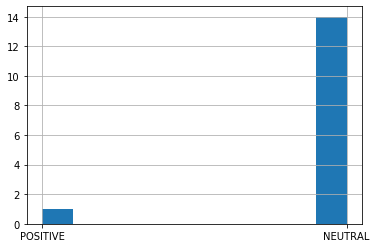

In [240]:
df['Sentiment'].hist()

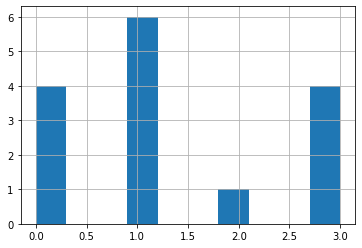

In [244]:
df["retweet_count"].hist()

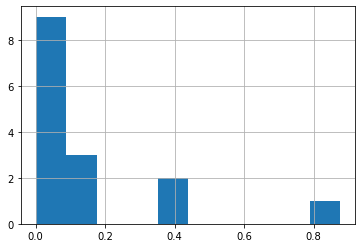

In [245]:
df["SentimentScorePositive"].hist()

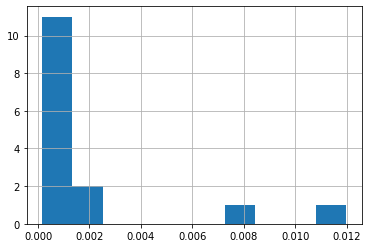

In [246]:
df["SentimentScoreNegative"].hist()

## Análisis de entidades

In [248]:
entities = comprehend.batch_detect_entities(LanguageCode="es",TextList=df['text'].tolist())

In [251]:
entities['ResultList'][0]

{'Index': 0,
 'Entities': [{'Score': 0.9985061287879944,
   'Type': 'PERSON',
   'Text': 'MonicaOspinaL',
   'BeginOffset': 4,
   'EndOffset': 17},
  {'Score': 0.6213843822479248,
   'Type': 'ORGANIZATION',
   'Text': 'awscloud',
   'BeginOffset': 28,
   'EndOffset': 36},
  {'Score': 0.5186120271682739,
   'Type': 'LOCATION',
   'Text': 'Colombia',
   'BeginOffset': 102,
   'EndOffset': 110}]}

In [256]:
entities = [result['Entities'] for result in entities['ResultList']]

In [269]:
tweetentitiesList = []
for tweetentities in entities:
    text = ''
    for val in tweetentities:
        text += val['Type']+':'+val['Text']+","
    tweetentitiesList.append(text)

In [270]:
tweetentitiesList

['PERSON:MonicaOspinaL,ORGANIZATION:awscloud,LOCATION:Colombia,',
 'PERSON:AleRam0923,TITLE:#java,TITLE:#awscloud,TITLE:#angular,TITLE:#ios,TITLE:#android,TITLE:#androidsdk,',
 'PERSON:AleRam0923,TITLE:#java,TITLE:#awscloud,TITLE:#angular,TITLE:#ios,TITLE:#android,TITLE:#androidsdk,',
 'PERSON:AleRam0923,TITLE:#java,TITLE:#awscloud,TITLE:#angular,TITLE:#ios,TITLE:#android,TITLE:#androidsdk,',
 'OTHER:https://t.co/6YXNP4O2YO,',
 'OTHER:https://t.co/rXjZ4X8bGY,',
 'TITLE:#java,TITLE:#awscloud,TITLE:#angular,TITLE:#ios,TITLE:#android,TITLE:#xcode,TITLE:#androidsdk,OTHER:https://t.co/s0n4SJcDna,',
 'ORGANIZATION:SanAbarc,QUANTITY:5 líderes,',
 'PERSON:SanAbarc,',
 'PERSON:SanAbarc,OTHER:AWS,',
 'ORGANIZATION:SanAbarc,QUANTITY:primera aplicación web,TITLE:AWS,ORGANIZATION:Twitch,TITLE:Let’s,',
 'PERSON:SanAbarc,TITLE:AWS Data Analytics,DATE:27A…,',
 'PERSON:Hilary Foster,ORGANIZATION:CEPREDENAC,OTHER:https://t.co/8xMV56RpXK,',
 'PERSON:POTUS,PERSON:Joe Biden,OTHER:https://t.co/RWHuSc8iVF,',

In [273]:
df['entities'] = tweetentitiesList

In [274]:
df.head()

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,extended_entities,Sentiment,SentimentScorePositive,SentimentScoreNegative
0,2021-08-27 03:49:42+00:00,1431101591088734211,1431101591088734208,RT @MonicaOspinaL: Gracias @awscloud por este ...,False,"PERSON:MonicaOspinaL,ORGANIZATION:awscloud,LOC...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,2,0,False,False,es,NaN,NaN,POSITIVE,0.876189,0.000157
1,2021-08-26 22:30:06+00:00,1431021160188157952,1431021160188157952,RT @AleRam0923: #java #springboot #microservic...,False,"PERSON:AleRam0923,TITLE:#java,TITLE:#awscloud,...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://help.twitter.com/en/using-twi...",NaN,NaN,...,3,0,False,False,es,NaN,NaN,NEUTRAL,0.004021,0.001144
2,2021-08-26 22:13:32+00:00,1431016993600249866,1431016993600249856,RT @AleRam0923: #java #springboot #microservic...,False,"PERSON:AleRam0923,TITLE:#java,TITLE:#awscloud,...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://script.google.com"" rel=""nofol...",NaN,NaN,...,3,0,False,False,es,NaN,NaN,NEUTRAL,0.004021,0.001144
3,2021-08-26 21:47:24+00:00,1431010416633683973,1431010416633683968,RT @AleRam0923: #java #springboot #microservic...,False,"PERSON:AleRam0923,TITLE:#java,TITLE:#awscloud,...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""https://help.twitter.com/en/using-twi...",NaN,NaN,...,3,0,False,False,es,NaN,NaN,NEUTRAL,0.004021,0.001144
4,2021-08-26 21:01:08+00:00,1430998772293804038,1430998772293804032,Las organizaciones están utilizando datos para...,True,"OTHER:https://t.co/6YXNP4O2YO,","{'iso_language_code': 'es', 'result_type': 're...","<a href=""http://www.everyonesocial.com"" rel=""n...",NaN,NaN,...,0,0,False,False,es,0.0,NaN,NEUTRAL,0.116296,0.002494
